#### import libraries and set notebook variables

In [ ]:
import pandas as pd
import torch
import tensorqtl.tensorqtl as tensorqtl
from tensorqtl.tensorqtl import genotypeio
print('PyTorch {}'.format(torch.__version__))
print('Pandas {}'.format(pd.__version__))
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
cohort = 'nabec'
version = 'Aug_2024'
target = 'cpg_islands'
gene_name = 'chr19_54982861_54983167_CpG:_30'
varianttype_caller = 'SV_harmonized_SNV'

In [ ]:
# naming
cohort_build = f'{cohort}.{version}'
cohort_version_target = f'{cohort}_{version}_{target}'
set_name = f'{cohort}_{version}_{target}_{varianttype_caller}'


interaction_term = None



if interaction_term == '':
    interaction_term = None

    term_file = None
# directories
in_dir = f'/data/CARDPB/data/NABEC/projects/QTL_paper_2024/SV-mQTL'
geno_dir = f'{in_dir}/genotypes/{varianttype_caller}'
quants_dir = f'{in_dir}/expression'
info_dir = f'{in_dir}/sample_info'
tensorqtl_dir = f'{in_dir}/tenosorqtl/{set_name}'
results_dir = f'{in_dir}/results/{set_name}'

# input files
qtl_results_file = f'{tensorqtl_dir}/{set_name}.cis.map.csv'
quants_bed_raw_file = f'{quants_dir}/{cohort_version_target}.raw_percentage.bed.gz'

if varianttype_caller == 'SNV_illumina':
    bfile_prefix_path = f'{geno_dir}/MERGED_MAF_GENO005_HWE_0001_ONT_plink19_Jul2024'
    
elif varianttype_caller ==  'SV_harmonized':
    bfile_prefix_path = f'{geno_dir}/nabec_GENO_MAF_005_HWE_0001_updateid'
elif varianttype_caller ==  'SV_harmonized_SNV':
    bfile_prefix_path = f'{geno_dir}/harmonized_SV_SNV_MAF_GENO_005_HWE_0001'

### get the variant name

In [ ]:
SIG_HITS = pd.read_csv(qtl_results_file)

display(SIG_HITS[SIG_HITS['phenotype_id']==gene_name])
variant=SIG_HITS[SIG_HITS['phenotype_id']==gene_name]['variant_id'].iloc[0]

#### load plink bfiles

%%time

# pr = genotypeio.PlinkReader(bfile_prefix_path, select_samples=phenotype_df.columns)
pr = genotypeio.PlinkReader(bfile_prefix_path)
genotype_df = pr.load_genotypes()
variant_df = pr.bim.set_index('snp')[['chrom', 'pos']]

#### load phenotypes and covariates (if needed)

In [10]:
%%time

phenotype_df = pd.read_csv(quants_bed_raw_file,index_col=0)
phenotype_df = phenotype_df.T

CPU times: user 1.69 s, sys: 46.7 ms, total: 1.74 s
Wall time: 1.78 s


In [11]:
display(phenotype_df.head())
# display(phenotype_pos_df.head())

,KEN-1066,KEN-1069,KEN-1070,KEN-1092,KEN-1095,KEN-1106,KEN-1127,KEN-1131,KEN-1132,KEN-1142,...,UMARY-602,UMARY-604,UMARY-650,UMARY-671,UMARY-794,UMARY-813,UMARY-818,UMARY-819,UMARY-914,UMARY-933
chr1_381172_382185_CpG:_84,84.347143,86.472143,91.612262,88.622051,87.155238,90.212738,90.228452,88.865595,86.666512,88.668929,...,89.259405,88.617500,91.521190,NaN,89.358421,85.555714,88.236190,87.395000,90.428214,86.123810
chr1_609358_611269_CpG:_171,93.843977,93.528304,93.053509,NaN,90.954444,93.209708,92.591170,93.556550,94.589649,91.675731,...,92.793392,92.146140,92.005906,94.389879,93.716257,89.063216,92.709298,92.262339,94.523275,93.618421
chr1_778604_779167_CpG:_60,5.436333,2.207667,4.441667,4.052333,4.366667,3.072500,3.627833,1.938500,4.886667,1.315833,...,1.676167,2.583333,1.860167,2.579333,2.986000,1.913667,4.361667,1.652833,2.368667,4.758333
chr1_866595_866958_CpG:_24,72.594167,63.636667,72.582174,70.010417,75.452500,70.335417,68.557500,73.422500,70.826957,75.184167,...,67.574583,67.895652,77.715417,74.161905,75.442917,74.000833,67.866522,75.707826,75.964583,72.073043
chr1_869818_870248_CpG:_50,14.138400,11.988600,10.570800,12.845000,12.367000,13.049400,12.711600,12.253200,11.276000,12.003600,...,9.947400,13.303000,10.937600,11.620400,15.603800,8.977000,13.433200,9.745400,10.391800,13.516000


In [12]:
if not interaction_term is None:
    covs_df = pd.read_csv(term_file, index_col=0)
    print(f'covariates_df {covs_df.shape}')
    # go ahead and subset to specified term of interest
    # have two different covariate and interaction term formats to deal with
    try:
        term_df = covs_df.loc[(covs_df['day'] == day) & 
                              (covs_df['sampleid'].isin(phenotype_df.columns)), 
                              ['day', 'sampleid', interaction_term]]
    except:
        term_df = covs_df.loc[(covs_df.index.isin(phenotype_df.columns)), 
                              [interaction_term]].copy()
        term_df['day'] = visit_name
        term_df['sampleid'] = term_df.index
    print(f'term_df {term_df.shape}')
#     display(term_df.head())
else:
    term_df = None

In [ ]:
variant_geno_df = genotype_df.loc[genotype_df.index == variant].T
print(variant_geno_df.shape)
# display(variant_geno_df.head())

#### merge the data frames

In [ ]:
merged_df = variant_geno_df.merge(gene_pheno_df, how='inner', 
                                  left_index=True, right_index=True)
print(merged_df.shape)
if not term_df is None:
    merged_df = merged_df.merge(term_df, how='inner', left_index=True, right_on='sampleid')

print(merged_df.shape)
# display(merged_df.head())

In [18]:
merged_df = merged_df[merged_df[variant]!=-1]

#### generate the plot(s)

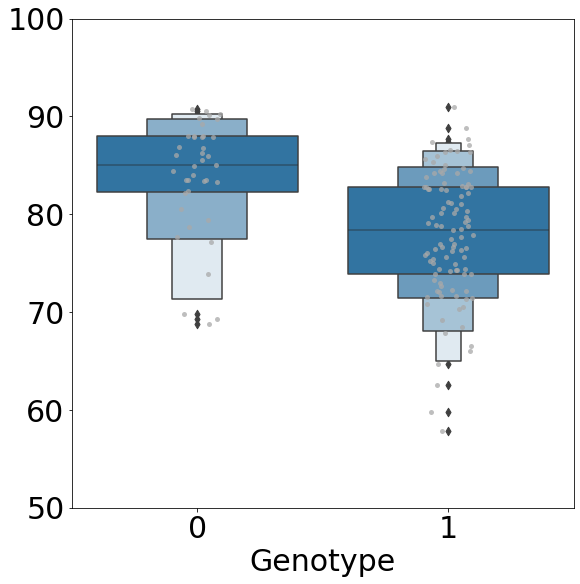

In [19]:
# plot typical expression by genotype plot
plt.figure(figsize=(9,9))
sns.boxenplot(x=variant, y=gene_name, scale='exponential', 
              data=merged_df, k_depth='trustworthy', color='#1f77b4')

# Overlay the strip plot
grsplt = sns.stripplot(x=variant, y=gene_name, data=merged_df, 
                       alpha=0.75, jitter=True, color='darkgrey')

# Increase the font size for ticks
loc, labels = plt.xticks(fontsize=30)  # Change fontsize here
grsplt.set_xticklabels(labels, fontsize=30)

plt.yticks(fontsize=30)  # Y-tick label fontsize
plt.ylim(50, 100)

#plt.title(f'{gene_name} expression by {variant} genotype', fontsize='large') 
plt.xlabel('Genotype', fontsize=30)
plt.ylabel('Methylation', fontsize=30)
plt.ylabel('', fontsize=30)  # Y-axis label fontsize
#plt.show()
plt.savefig(f'/data/CARDPB/data/NABEC/projects/QTL_paper_2024/newSV-mQTL/figures/{gene_name}_{variant}_expression.png', dpi=300)